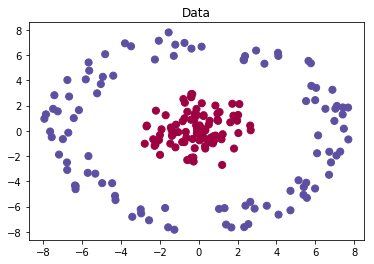

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def makeCraters(inner_rad=3, outer_rad=6, donut_len=2, inner_pts=100, outer_pts=100):
    N = 100  # number of points per class
    D = 2  # dimensionality
    K = 2  # number of classes
    X = np.zeros((N * K, D))  # data matrix (each row = single example)
    y = np.zeros(N * K, dtype='uint8')  # class labels
    #Make the inner core
    radius_core = inner_rad * np.random.random(inner_pts)
    direction_core = 2 * np.pi * np.random.random(size=inner_pts)

    # Simulate inner core points
    core_x = radius_core * np.cos(direction_core)
    core_y = radius_core * np.sin(direction_core)
    crater_core = zip(core_x, core_y)

    # Make the outer ring
    radius_ring = outer_rad + donut_len * np.random.random(outer_pts)
    direction_ring = 2 * np.pi * np.random.random(size=outer_pts)

    # Simulate ring points
    ring_x = radius_ring * np.cos(direction_ring)
    ring_y = radius_ring * np.sin(direction_ring)
    crater_ring = zip(ring_x, ring_y)

    ix1 = range(N * 0, N * (0 + 1))
    X[ix1] = np.array(list(crater_core))
    y[ix1] = 0

    ix2 = range(N * 1, N * (1 + 1))
    X[ix2] = np.array(list(crater_ring))
    y[ix2] = 1
    
    # lets visualize the data:
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.Spectral)
    plt.title('Data')
    plt.show()
    return X,y
    
X_train,labels=makeCraters()

In [4]:
#one-hot Encoding
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(n_values=2)
y_train_enc = ohe.fit_transform(labels.reshape(-1, 1)).toarray()

In [5]:
import numpy as np
from scipy.special import expit
from sklearn.metrics import accuracy_score
expit(-1000)
class FCNeuron(object):
    def __init__(self):
        self._w1 = None
        self._w2 = None
        self._b1 = None
        self._b2 = None
        self._w1_grad = 0
        self._w2_grad = 0
        self._b1_grad = 0
        self._b2_grad = 0
        self._x = None
        self._t = None

    def set_params(self, w, b):
        self._w1, self._w2 = w[0], w[1]
        self._b1, self._b2 = b[0], b[1]

    def forpass(self, x):
        self._x = x
        self._t = self._sigmoid(np.dot(self._x, self._w1) + self._b1)
        _y_hat = np.dot(self._t, self._w2) + self._b2
        return self._softmax(_y_hat)

    def backprop(self, err, lr=0.01):
        self._w2_grad = lr * np.dot(self._t.T, err) / self._x.shape[0]
        self._b2_grad = lr * np.average(err, axis=0)
        err2 = np.dot(err, self._w2.T)
        err2 *= self._t * (1 - self._t)
        self._w1_grad = lr * np.dot(self._x.T, err2) / self._x.shape[0]
        self._b1_grad = lr * np.average(err2, axis=0)

    def update_grad(self, l2=0):
        w1 = self._w1 + self._w1_grad - l2 * self._w1
        w2 = self._w2 + self._w2_grad - l2 * self._w2
        b1 = self._b1 + self._b1_grad
        b2 = self._b2 + self._b2_grad
        self.set_params([w1, w2], [b1, b2])
        
    def fit(self, X, y, n_iter=5000, lr=0.1, l2=1e-3):
        cost = []
        for i in range(n_iter):
            y_hat = self.forpass(X)
            error = y - y_hat
            self.backprop(error, lr)
            self.update_grad(l2 / y.shape[0])
            
            y_hat = np.clip(y_hat, 0.00001, 0.99999)
            cost.append(-np.sum(y * np.log(y_hat)) / y.shape[0])
            if i % 500 == 0:
                print("At step",i, "Loss is ",(-np.sum(y * np.log(y_hat)) / y.shape[0]))
        return cost

    def predict(self, X):
        y_hat = self.forpass(X)
        return np.argmax(y_hat, axis=1)

    def _sigmoid(self, y_hat):
        return expit(y_hat)

    def _softmax(self, y_hat):
        tmp = y_hat - y_hat.max(axis=1).reshape(-1, 1)
        exp_tmp = np.exp(tmp)
        return exp_tmp / exp_tmp.sum(axis=1).reshape(-1, 1)

At step 0 Loss is  0.716028710202
At step 500 Loss is  0.414453448219
At step 1000 Loss is  0.167311153279
At step 1500 Loss is  0.0759898525072
At step 2000 Loss is  0.046891552469
At step 2500 Loss is  0.0337699533662
At step 3000 Loss is  0.0264122902854
At step 3500 Loss is  0.0217208366942
At step 4000 Loss is  0.0184703497864
At step 4500 Loss is  0.0160852793764
Accuracy: 1.00


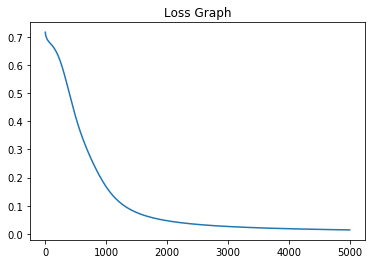

In [6]:
n4 = FCNeuron()
bound = np.sqrt(1./2)
w1 = np.random.uniform(-bound, bound, (2, 8))
b1 = np.random.uniform(-bound, bound, 8)
bound = np.sqrt(1./8)
w2 = np.random.uniform(-bound, bound, (8, 2))
b2 = np.random.uniform(-bound, bound, 2)
n4.set_params([w1, w2], [b1, b2])
costs = n4.fit(X_train, y_train_enc, 5000, 0.1) 
y_hat = n4.predict(X_train)
print('Accuracy: %.2f' %accuracy_score(labels, y_hat))
plt.plot(costs)
plt.title('Loss Graph')
plt.show()

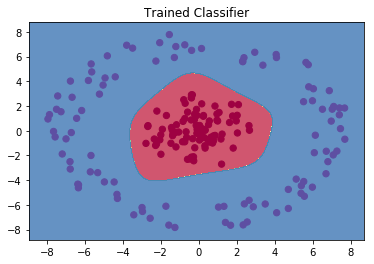

In [7]:
# plot the resulting classifier
h = 0.01
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = n4.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels, s=40, cmap=plt.cm.Spectral)
plt.title('Trained Classifier')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()